In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import mir_eval
import scipy


import oracles

import matplotlib.pyplot as plt
import matplotlib

In [2]:
def fast_intersect(ref, est):
    """Find all intersections between reference events and estimated events (fast).
    Best-case complexity: O(N log N + M log M) where N=length(ref) and M=length(est)

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.


    Returns
    -------
    matches: list of sets, length n, integer-valued
         Property: matches[i] contains the set of all indices j such that
            (ref[0, i]<=est[1, j]) AND (ref[1, i]>=est[0, j])
    """
    ref_on_argsort = np.argsort(ref[0, :])
    ref_off_argsort = np.argsort(ref[1, :])

    est_on_argsort = np.argsort(est[0, :])
    est_off_argsort = np.argsort(est[1, :])

    est_on_maxindex = est.shape[1]
    est_off_minindex = 0
    estref_matches = [set()] * ref.shape[1]
    refest_matches = [set()] * ref.shape[1]
    for ref_id in range(ref.shape[1]):
        ref_onset = ref[0, ref_on_argsort[ref_id]]
        est_off_sorted = est[1, est_off_argsort[est_off_minindex:]]
        search_result = np.searchsorted(est_off_sorted, ref_onset, side="left")
        est_off_minindex += search_result
        refest_match = est_off_argsort[est_off_minindex:]
        refest_matches[ref_on_argsort[ref_id]] = set(refest_match)

        ref_offset = ref[1, ref_off_argsort[-1 - ref_id]]
        est_on_sorted = est[0, est_on_argsort[: (1 + est_on_maxindex)]]
        search_result = np.searchsorted(est_on_sorted, ref_offset, side="right")
        est_on_maxindex = search_result - 1
        estref_match = est_on_argsort[: (1 + est_on_maxindex)]
        estref_matches[ref_off_argsort[-1 - ref_id]] = set(estref_match)

    zip_iterator = zip(refest_matches, estref_matches)
    matches = [x.intersection(y) for (x, y) in zip_iterator]
    return matches


def iou(ref, est, method="fast"):
    """Compute pairwise "intersection over union" (IOU) metric between reference
    events and estimated events.

    Let us denote by a_i and b_i the onset and offset of reference event i.
    Let us denote by u_j and v_j the onset and offset of estimated event j.

    The IOU between events i and j is defined as
        (min(b_i, v_j)-max(a_i, u_j)) / (max(b_i, v_j)-min(a_i, u_j))
    if the events are non-disjoint, and equal to zero otherwise.

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    method: str, optional.
         If "fast" (default), computes pairwise intersections via a custom
         dynamic programming algorithm, see fast_intersect.
         If "slow", computes pairwise intersections via bruteforce quadratic
         search, see slow_intersect.

    Returns
    -------
    S: scipy.sparse.dok.dok_matrix, real-valued
        Sparse 2-D matrix. S[i,j] contains the IOU between ref[i] and est[j]
        if these events are non-disjoint and zero otherwise.
    """
    n_refs = ref.shape[1]
    n_ests = est.shape[1]
    S = scipy.sparse.dok_matrix((n_refs, n_ests))

    if method == "fast":
        matches = fast_intersect(ref, est)
    elif method == "slow":
        matches = slow_intersect(ref, est)

    for ref_id in range(n_refs):
        matching_ests = matches[ref_id]
        ref_on = ref[0, ref_id]
        ref_off = ref[1, ref_id]

        for matching_est_id in matching_ests:
            est_on = est[0, matching_est_id]
            est_off = est[1, matching_est_id]
            intersection = min(ref_off, est_off) - max(ref_on, est_on)
            union = max(ref_off, est_off) - min(ref_on, est_on)
            intersection_over_union = intersection / union
            S[ref_id, matching_est_id] = intersection_over_union

    return S


def match_events(ref, est, min_iou=0.0, method="fast"):
    """
    Compute a maximum matching between reference and estimated event times,
    subject to a criterion of minimum intersection-over-union (IOU).

    Given two lists of events ``ref`` (reference) and ``est`` (estimated),
    we seek the largest set of correspondences ``(ref[i], est[j])`` such that
        ``iou(ref[i], est[j]) <= min_iou``
    and such that each ``ref[i]`` and ``est[j]`` is matched at most once.

    This function is strongly inspired by mir_eval.onset.util.match_events.
    It relies on mir_eval's implementation of the Hopcroft-Karp algorithm from
    maximum bipartite graph matching. However, one important difference is that
    mir_eval's distance function relies purely on onset times, whereas this function
    considers both onset times and offset times to compute the IOU metric between
    reference events and estimated events.

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    min_iou: real number in [0, 1). Default: 0.
         Threshold for minimum amount of intersection over union (IOU) to match
         any two events. See the iou method for implementation details.

    method: str, optional.
         If "fast" (default), computes pairwise intersections via a custom
         dynamic programming algorithm, see fast_intersect.
         If "slow", computes pairwise intersections via bruteforce quadratic
         search, see slow_intersect.

    Returns
    -------
    matching : list of tuples
        Every tuple corresponds to a match between one reference event and
        one estimated event.
            ``matching[i] == (i, j)`` where ``ref[i]`` matches ``est[j]``.
        Note that all values i and j appear at most once in the list.
    """

    # Intersect reference events and estimated events
    S = iou(ref, est, method=method)

    # Threshold intersection-over-union (IOU) ratio
    S_bool = scipy.sparse.dok_matrix(S > min_iou)
    hits = S_bool.keys()

    # Construct the bipartite graph
    G = {}
    for ref_i, est_i in hits:
        if est_i not in G:
            G[est_i] = []
        G[est_i].append(ref_i)

    # Apply Hopcroft-Karp algorithm (from mir_eval package)
    # to obtain maximum bipartite graph matching
    matching = sorted(mir_eval.util._bipartite_match(G).items())
    return matching


def slow_intersect(ref, est):
    """Find all intersections between reference events and estimated events (slow).
    Best-case complexity: O(N*M) where N=ref.shape[1] and M=est.shape[1]

    Parameters
    ----------
    ref: np.ndarray [shape=(2, n)], real-valued
         Array of reference events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.

    est: np.ndarray [shape=(2, m)], real-valued
         Array of estimated events. Each column is an event.
         The first row denotes onset times and the second row denotes offset times.


    Returns
    -------
    matches: list of sets, length n, integer-valued
         Property: matches[i] contains the set of all indices j such that
            (ref[0, i]<=est[1, j]) AND (ref[1, i]>=est[0, j])
    """
    matches = []
    for i in range(ref.shape[1]):
        matches.append(
            set(
                [
                    j
                    for j in range(est.shape[1])
                    if ((ref[0, i] <= est[1, j]) and (ref[1, i] >= est[0, j]))
                ]
            )
        )
    return matches

In [63]:
def compute_tp_fp_fn(events_ref, events_pred, min_iou=0.3):

    if len(events_pred) == 0:
        return 0, 0, len(events_ref), len(events_ref)
    
    events_ref_ndarray = np.array(events_ref).transpose() # shape (n, 2) -> (2, n)
    events_pred_ndarray = np.array(events_pred).transpose() # shape (m, 2) -> (2, m)

    matches = match_events(events_ref_ndarray, events_pred_ndarray, min_iou=min_iou)
    tp = len(matches)
    fp = len(events_pred) - tp
    fn = len(events_ref) - tp
    total_events = len(events_ref)

    return tp, fp, fn, total_events

def precision_score(tp, fp):
    return tp / (tp + fp)

def recall_score(tp, fn):
    return tp / (tp + fn)

def f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall)

def f1_score_from_events(events_ref, events_pred, min_iou):
    tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred, min_iou)

    # TODO: what should this be?
    if tp + fp == 0:
        return 0
    
    precision = precision_score(tp, fp)
    recall    = recall_score(tp, fn)

    # TODO: what should this be?
    if precision + recall == 0:
        return 0
    
    f1 = f1_score(precision, recall)
    return f1

print("Test 1.")
print("----------------------------------------")
events_ref  = [(0,1), (2,3), (4,5)]
events_pred = [(0,1),        (4,5)]
print("expected : tp = 2, fp = 0, fn = 1")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))

precision = precision_score(tp, fp)
recall = recall_score(tp, fn)
f1 = f1_score(precision, recall)
print("expected precision: 1.0")
print("output   precision: {}".format(precision))
print("expected recall: 0.67")
print("output   precision: {:.2f}".format(recall))
print("expected f1 score: 0.80")
print("output   f1 score: {:.2f}".format(f1))
print("----------------------------------------")

print("Test 2.")
print("----------------------------------------")
events_ref  = [(0,1), (2,3), (4,5)]
events_pred = [(0,1), (1,2), (4,5)]
print("expected : tp = 2, fp = 1, fn = 1")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))
print("----------------------------------------")

print("Test 3.")
print("----------------------------------------")
events_ref  = [(0,1),   (2,3),   (4,5)]
events_pred = [(0,0.5), (2,2.5), (4,4.5)]
print("expected : tp = 3, fp = 0, fn = 0")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred, min_iou=0.3)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))
print("----------------------------------------")

print("Test 4.")
print("----------------------------------------")
events_ref  = [(0,1),   (2,3),   (4,5)]
events_pred = [(0,0.5), (2,2.5), (4,4.5)]
print("expected : tp = 0, fp = 3, fn = 3")
tp, fp, fn, total_events = compute_tp_fp_fn(events_ref, events_pred, min_iou=0.6)
print("output   : tp = {}, fp = {}, fn = {}".format(tp, fp, fn))
print("----------------------------------------")

Test 1.
----------------------------------------
expected : tp = 2, fp = 0, fn = 1
output   : tp = 2, fp = 0, fn = 1
expected precision: 1.0
output   precision: 1.0
expected recall: 0.67
output   precision: 0.67
expected f1 score: 0.80
output   f1 score: 0.80
----------------------------------------
Test 2.
----------------------------------------
expected : tp = 2, fp = 1, fn = 1
output   : tp = 2, fp = 1, fn = 1
----------------------------------------
Test 3.
----------------------------------------
expected : tp = 3, fp = 0, fn = 0
output   : tp = 3, fp = 0, fn = 0
----------------------------------------
Test 4.
----------------------------------------
expected : tp = 0, fp = 3, fn = 3
output   : tp = 0, fp = 3, fn = 3
----------------------------------------


In [53]:
def load_annotations(ref_path):
    annotations = []
    
    with open(ref_path, 'r') as f:
        ls = f.readlines()
        for l in ls:
            ds = l.split('\t')
            start_time = float(ds[0])
            end_time = float(ds[1])
            #class_name = ds[2]
            #annotations.append((start_time, end_time, class_name))
            annotations.append((start_time, end_time))
    return annotations
    
def compute_neg_ref(pos_ref):
    start_times = [start_time for (start_time, _) in pos_ref]
    end_times = [end_time for (_, end_time) in pos_ref]
    _end_times   = start_times[1:]
    _start_times = end_times[:-1]

    return list(zip(_start_times, _end_times))

In [61]:
def annotator_cost(start_time, end_time, cost_linear, cost_overhead):
    segment_cost = (end_time - start_time) * cost_linear + cost_overhead
    return segment_cost

base_dir = '../soundscapes/ME/test'
soundscape_basename = 'ME1'

ref_path = os.path.join(base_dir, '{}.txt'.format(soundscape_basename))
me1_pos_ref = load_annotations(ref_path)
me1_neg_ref = compute_neg_ref(me1_pos_ref)

oracle = oracles.WeakLabelOracle(base_dir = base_dir)


file_end_time = me1_pos_ref[-1][1]

n_segment_lengths = 50
min_segment_length = 0.1
max_segment_length = 30
segment_lengths = np.linspace(min_segment_length, max_segment_length, n_segment_lengths)

n_cost_overheads = 50
min_cost_overhead = 0
max_cost_overhead = 20
cost_overheads = np.linspace(min_cost_overhead, max_cost_overhead, n_cost_overheads)

# label_quality_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))
# cost_ratio_result = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_fixed = np.zeros((n_segment_lengths, n_cost_overheads))
cost_fixed = np.zeros((n_segment_lengths, n_cost_overheads))

label_quality_oracle = np.zeros((n_segment_lengths, n_cost_overheads))
cost_oracle = np.zeros((n_segment_lengths, n_cost_overheads))


cost_linear = 1
min_iou = 0.01 #0.025 * 3

#segment_lengths = [1.0]
#cost_overheads = [100.0]

for idx_seg, segment_length in enumerate(segment_lengths):
    for idx_cost, cost_overhead in enumerate(cost_overheads):

        # ORACLE: compute cost of optimal query strategy (recovers true labels using weak-labels)
        cost_opt_query_pos = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_pos_ref])
        cost_opt_query_neg = np.sum([annotator_cost(st, et, cost_linear, cost_overhead) for (st, et) in me1_neg_ref])
        cost_opt_query = cost_opt_query_neg + cost_opt_query_pos
        f1_opt = f1_score_from_events(me1_pos_ref, me1_pos_ref, min_iou=min_iou)

        # FIXED: compute cost of segment query strategy
        time_counter = 0.0
        cost_fix_query = 0.0
        me1_pos_pred = []
        
        # simulate annotation of the whole file
        while time_counter < file_end_time:
            query_start_time = time_counter
            query_end_time   = time_counter + (segment_length)
    
            # get annotation
            c = oracle.query(query_start_time, query_end_time, soundscape_basename)
            if c == 1:
                me1_pos_pred.append((query_start_time, query_end_time))
    
            # get cost
            cost = annotator_cost(query_start_time, query_end_time, cost_linear, cost_overhead)
            cost_fix_query += cost
    
            # increase time counter
            time_counter += segment_length

        f1 = f1_score_from_events(me1_pos_ref, me1_pos_pred, min_iou=min_iou)
    
        # cost_ratio = cost_opt_query / (cost_opt_query + cost_fix_query)
        # label_quality_ratio = f1_opt / (f1_opt + f1)

        # label_quality_ratio_result[idx_seg, idx_cost] = label_quality_ratio
        # cost_ratio_result[idx_seg, idx_cost] = cost_ratio

        # label_quality_fixed = np.zeros((n_segment_lengths, n_cost_overheads))

        label_quality_fixed[idx_seg, idx_cost] = f1
        cost_fixed[idx_seg, idx_cost] = cost_fix_query
        
        label_quality_oracle[idx_seg, idx_cost] = f1_opt
        cost_oracle[idx_seg, idx_cost] = cost_opt_query

        #result[idx_seg, idx_cost] = (cost_ratio + label_quality_ratio) / 2

#print("cost opt. query = {:.2f}, label-quality = {:.2f}".format(cost_opt_query, f1_opt))

(50, 50)
(50, 50)
0.43915399422756474


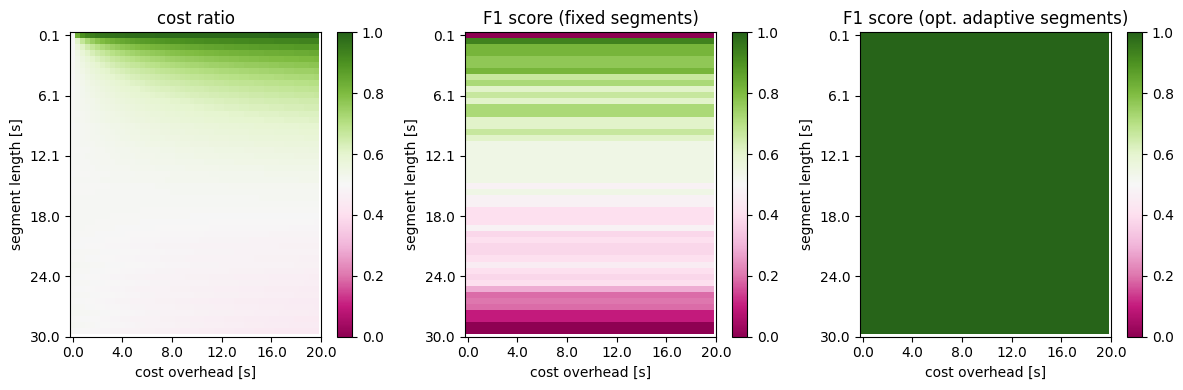

In [62]:
cost_ratio_result = cost_fixed / (cost_fixed + cost_oracle)
label_quality_ratio_result = label_quality_fixed #1 / (1 + label_quality_fixed)
print(label_quality_ratio_result.shape)
print(cost_ratio_result.shape)


cmap = matplotlib.colormaps['PiYG']

fig, ax = plt.subplots(1,3, figsize=(12,4))

img0 = ax[0].imshow(cost_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[0].set_title('cost ratio')
plt.colorbar(img0, ax=ax[0])

img1 = ax[1].imshow(label_quality_ratio_result, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[1].set_title('F1 score (fixed segments)')
plt.colorbar(img1, ax=ax[1])


img2 = ax[2].imshow(label_quality_oracle, vmin=0, vmax=1, cmap=cmap, aspect='auto')
ax[2].set_title('F1 score (opt. adaptive segments)')
plt.colorbar(img2, ax=ax[2])

for idx in [0, 1, 2]:
    # set xticks
    xticks = ax[idx].get_xticks()[1:]
    #print(xticks)
    xticklabels = np.linspace(min_cost_overhead, max_cost_overhead, len(xticks))
    xticklabels = ['{:.1f}'.format(c) for c in xticklabels]
    #print(xticklabels)
    ax[idx].set_xticks(xticks)
    ax[idx].set_xticklabels(xticklabels)
    ax[idx].set_xlabel('cost overhead [s]')
    
    # set yticks
    yticks = ax[idx].get_yticks()[1:]
    #print("y: ", yticks)
    yticklabels = np.linspace(min_segment_length, max_segment_length, len(yticks))
    yticklabels = ['{:.1f}'.format(c) for c in yticklabels]
    #print("yticklabels: ", yticklabels)
    ax[idx].set_yticks(yticks)
    ax[idx].set_yticklabels(yticklabels)
    ax[idx].set_ylabel('segment length [s]')

plt.tight_layout()
print(np.min(cost_ratio_result))

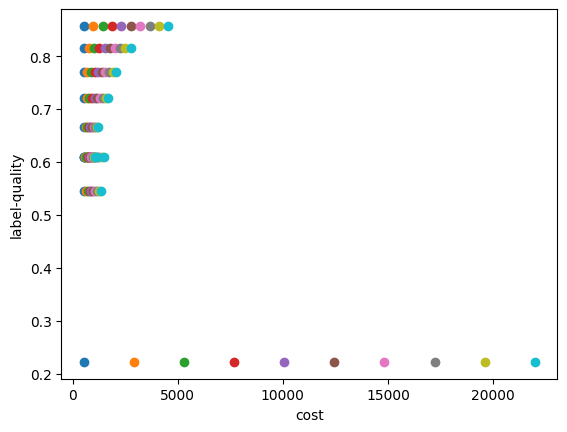

In [42]:
colors = ['red', 'green', 'blue', 'purple']

for idx_seg in range(len(segment_lengths)):
    for idx_cost in range(len(cost_overheads)):
        x_b = cost_fixed[idx_seg, idx_cost]
        y_b = label_quality_fixed[idx_seg, idx_cost]
        
        plt.scatter(x_b, y_b)

plt.ylabel('label-quality')
plt.xlabel('cost')
plt.show()

(2, 2)


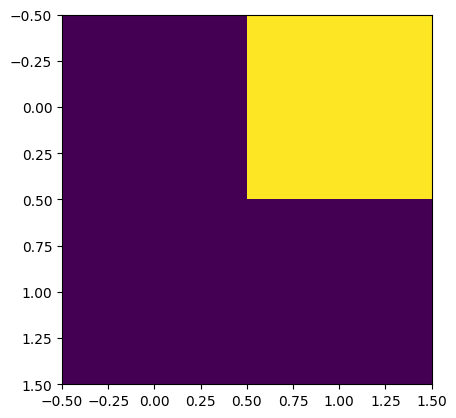

In [33]:
x = np.array([
    [0, 1],
    [0, 0]
])
print(x.shape)
plt.imshow(x)

In [8]:
# measure of label quality

# Baseline: fixed segment lengths
# simulate weak-labelling approach with fixed length segments
# 1. true label
# 2. sliding window with max

# compute cost of fixed length segment approach
# Oracle: optimal adaptive segment lengths
# compute cost of optimal adaptive segments approach

# Human: simulate sub-optimal adaptive segments approach, taking human characteristics into account
# 1. set minimum and maximum segment lengths
# 2. come up with reasonable heuristic
#     a. for all events shorter than min, place window on top of them
#     b. for all events longer than max, distribute window inside
#     c. for all remaining events, place optimal window on them
#     d. derive labels

# simulate annotator quality, if window overlaps too little with event, add label noise

# Figure 1. Label quality on y-axis, annotator cost on x-axis
# Baseline: plot this for different segment lengths, varying between minimum event length to maximum event length
# Oracle: plot this optimal point in figure. This is the least amount of annotation necessary (under the assumed cost model) to derive optimal labels.
# Human: plot this sub-optimal point in figure. This is approximately the least amount of annotation necessary to derive the sub-optimal labels.
#
# The idea of figure 1 is to convince the reader that the persuit of adaptive segmentation lengths can have benefits, 
# and to understand better under which scenarios it will have benefits. I think this is important.

# Things to vary.
#
# Annotator model. Different assumptions on label noise for sub-optimal overlap with event of interest.
# Cost model. Different assumptions on the constant overhead cost and the gradient for the linear cost.